In [283]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


seed = 1
%matplotlib inline

In [292]:
TRAIN_PATH = "train.csv"
TEST_PATH = "test.csv"


train = pd.read_csv(TRAIN_PATH, sep=';')
test = pd.read_csv(TEST_PATH, sep=';')

In [293]:
# Так как по условию building_id и listing_id использовать нельзя
# То лучше их удалить
train = train.drop(columns={"building_id", "listing_id"})
train.columns

Index(['bathrooms', 'bedrooms', 'created', 'description', 'display_address',
       'features', 'latitude', 'longitude', 'manager_id', 'photos', 'price',
       'street_address', 'interest_level'],
      dtype='object')

<AxesSubplot:>

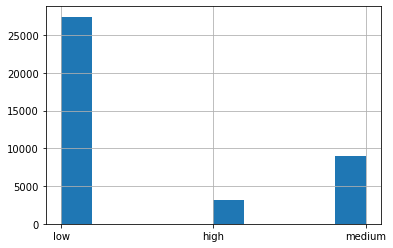

In [294]:
# Посмотрим на распределение классов
train.interest_level.hist()

In [295]:
train.interest_level.value_counts(normalize=True)

low       0.695170
medium    0.226463
high      0.078367
Name: interest_level, dtype: float64

## EDA

In [296]:
# Преобразуем классы к числам
# Чтобы мы смогли удобнее с нимми работать
mapper={
        'low':0,
        'medium':1,
        'high':2
       }

train['interest_level'] = train['interest_level'].apply(mapper.__getitem__)

In [297]:
# Генерация фичей по заданию
train['features'] = train['features'].str.replace('[\[\]\']', '').str.split(', ')

<ipython-input-297-b667128c7a91>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train['features'] = train['features'].str.replace('[\[\]\']', '').str.split(', ')


In [298]:
train['photos'] = train.photos.str.replace('[\[\]\']', '').str.split(', ')
train['num_photos'] = train['photos'].apply(len)
train["num_description_words"] = train['description'].str.replace('<.*?>', '').str.split().fillna('').apply(len)

<ipython-input-298-06d261a0a3d3>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['photos'] = train.photos.str.replace('[\[\]\']', '').str.split(', ')
<ipython-input-298-06d261a0a3d3>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train["num_description_words"] = train['description'].str.replace('<.*?>', '').str.split().fillna('').apply(len)


In [299]:
train.head()

,bathrooms,bedrooms,created,description,display_address,features,latitude,longitude,manager_id,photos,price,street_address,interest_level,num_photos,num_description_words
0,1.0,0,2016-06-02 04:21:46,AMAZING STUDIO!! CONVENIENT TO ALL - G...,Gold Street,"[Cats Allowed, Dogs Allowed]",40.6969,-73.9830,79d1809d224bc7f26c719f247d6c8dc6,[https://photos.renthop.com/2/7097709_8f74305e...,2575,257 Gold Street,0,10,317
1,1.0,2,2016-05-26 05:44:12,"Near NYU, Washington SQ Park, centrally locate...",Thompson Street,[],40.7264,-74.0013,e60b02e0cfd2eea7d777bb283d6f8d4d,[https://photos.renthop.com/2/7071860_32b196af...,3250,128 Thompson Street,2,5,11
2,1.0,0,2016-06-17 01:22:32,RENT STABILIZED! FULL TIME DOORMAN.LEXINGTON A...,East 35th Street,"[Doorman, Dogs Allowed, Cats Allowed]",40.7466,-73.9779,91a276fdb4c7ae5ff56fd0884b5121db,[https://photos.renthop.com/2/7174524_bde8df9d...,2448,165 East 35th Street,0,1,85
3,1.0,1,2016-06-03 05:26:40,WHY TO LIVE IN THIS LUXURIOUS BUILDING? WEEKDA...,West 42nd Street,"[Swimming Pool, Roof Deck, Dining Room, Doorma...",40.7610,-73.9992,cbcd513212d592e6c717d27be14f46ac,[https://photos.renthop.com/2/7104515_bab07536...,3300,610 West 42nd Street,0,6,123
4,2.0,0,2016-04-12 04:10:28,Listed on the National Register of His...,Greenwich Street,"[Doorman, Fitness Center, No Fee]",40.7324,-74.0081,b209e2c4384a64cc307c26759ee0c651,[https://photos.renthop.com/2/6859942_16f88f7f...,5450,666 Greenwich Street,0,8,63


## Менеджеры
**Идеи**:
1. Посчитать для каждого менеджера кол-во заявок
2. Посчитать эффективность менеджера. Так как много менеджеров, которые создают много заявок.Однако интерес этих заявок низкий. Поэтому можно подсчитать средний интерес заявки для каждого менеджера
3. Скомбинировать пункты 1 и 2 и получить что-то вроде рейтинга менеджера. По идее успешный менеджер тот, кто выкладывает много заявок с высоким интересом


In [301]:
# Кол-во заявок на каждого менеджера
manger_counts = train.manager_id.value_counts()
manger_counts.head()

e6472c7237327dd3903b3d6f6a94515a    2035
6e5c10246156ae5bdcd9b487ca99d96a     576
8f5a9c893f6d602f4953fcc0b8e6e9b4     333
62b685cc0d876c3a1a51d63a0d6a8082     315
cb87dadbca78fad02b388dc9e8f25a5b     307
Name: manager_id, dtype: int64

In [302]:
# Средний интерес заявки для менеджера
manager_efficiency = train.groupby("manager_id").interest_level.mean()
manager_efficiency.head()

manager_id
0000abd7518b94c35a90d64b56fbf3e6    0.727273
001ce808ce1720e24a9510e014c69707    0.000000
003fc4e9a70053082f131b1054966aaf    0.000000
00607a02f6efd9c6c7c588826e471ee9    1.000000
00995ff28d79127ed2dca8320e9e7d09    0.333333
Name: interest_level, dtype: float64

In [303]:
# Рейтинг менеджера
rating = manager_efficiency * np.log(manger_counts)
rating.head()

0000abd7518b94c35a90d64b56fbf3e6    1.743924
001ce808ce1720e24a9510e014c69707    0.000000
003fc4e9a70053082f131b1054966aaf    0.000000
00607a02f6efd9c6c7c588826e471ee9    0.693147
00995ff28d79127ed2dca8320e9e7d09    0.366204
dtype: float64

In [307]:
train["manager_count"] = train.manager_id.apply(manger_counts.__getitem__)
train["manager_exp"] = train.manager_id.apply(manager_efficiency.__getitem__)
train["manager_rating"] = train.manager_id.apply(rating.__getitem__)

In [308]:
train.head()

,bathrooms,bedrooms,created,description,display_address,features,latitude,longitude,manager_id,photos,price,street_address,interest_level,num_photos,num_description_words,manager_exp,manager_rating,manager_count
0,1.0,0,2016-06-02 04:21:46,AMAZING STUDIO!! CONVENIENT TO ALL - G...,Gold Street,"[Cats Allowed, Dogs Allowed]",40.6969,-73.9830,79d1809d224bc7f26c719f247d6c8dc6,[https://photos.renthop.com/2/7097709_8f74305e...,2575,257 Gold Street,0,10,317,0.000000,0.000000,3
1,1.0,2,2016-05-26 05:44:12,"Near NYU, Washington SQ Park, centrally locate...",Thompson Street,[],40.7264,-74.0013,e60b02e0cfd2eea7d777bb283d6f8d4d,[https://photos.renthop.com/2/7071860_32b196af...,3250,128 Thompson Street,2,5,11,0.777778,1.708952,9
2,1.0,0,2016-06-17 01:22:32,RENT STABILIZED! FULL TIME DOORMAN.LEXINGTON A...,East 35th Street,"[Doorman, Dogs Allowed, Cats Allowed]",40.7466,-73.9779,91a276fdb4c7ae5ff56fd0884b5121db,[https://photos.renthop.com/2/7174524_bde8df9d...,2448,165 East 35th Street,0,1,85,0.000000,0.000000,35
3,1.0,1,2016-06-03 05:26:40,WHY TO LIVE IN THIS LUXURIOUS BUILDING? WEEKDA...,West 42nd Street,"[Swimming Pool, Roof Deck, Dining Room, Doorma...",40.7610,-73.9992,cbcd513212d592e6c717d27be14f46ac,[https://photos.renthop.com/2/7104515_bab07536...,3300,610 West 42nd Street,0,6,123,0.400000,1.360479,30
4,2.0,0,2016-04-12 04:10:28,Listed on the National Register of His...,Greenwich Street,"[Doorman, Fitness Center, No Fee]",40.7324,-74.0081,b209e2c4384a64cc307c26759ee0c651,[https://photos.renthop.com/2/6859942_16f88f7f...,5450,666 Greenwich Street,0,8,63,0.120690,0.622645,174


<AxesSubplot:xlabel='manager_exp', ylabel='Count'>

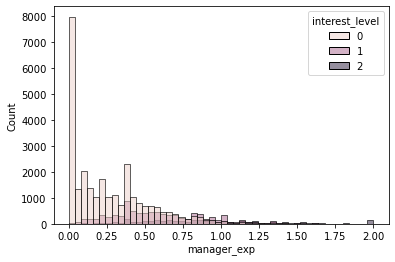

In [310]:
# Кол-во менеджеров по их среднему интересу
sns.histplot(train,
             x="manager_exp",
             hue="interest_level",
             bins=50,
            )

<AxesSubplot:xlabel='manager_rating', ylabel='Count'>

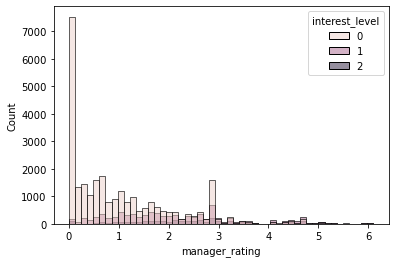

In [311]:
# Кол-во менеджеров по их рейтингу
sns.histplot(train,
             x="manager_rating",
             hue="interest_level",
             bins=50,
            )

<AxesSubplot:xlabel='manager_count', ylabel='Count'>

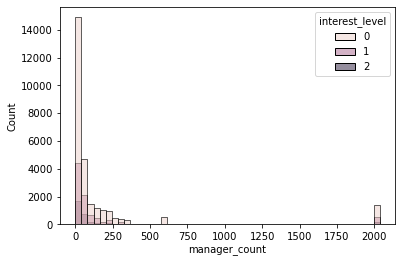

In [313]:
# Кол-во менеджеров по их количеству заявок
# Здесь можно заметить, что с возрастанием кол-ва заявок
# Интерес самих заявок уменьшается
sns.histplot(train,
             x="manager_count",
             hue="interest_level",
             bins=50,
            )

## Анализ зависимости от времени

**Переводим время к формату datetime**

In [231]:
train.created = pd.to_datetime(train.created)
train.created

0       2016-06-02 04:21:46
1       2016-05-26 05:44:12
2       2016-06-17 01:22:32
3       2016-06-03 05:26:40
4       2016-04-12 04:10:28
                ...        
39476   2016-06-20 18:09:47
39477   2016-04-26 05:40:27
39478   2016-04-10 03:20:09
39479   2016-06-03 03:53:35
39480   2016-06-15 02:29:10
Name: created, Length: 39481, dtype: datetime64[ns]

In [233]:
time_train = train.sort_values(by=["created"])
time_train

,bathrooms,bedrooms,created,description,display_address,features,latitude,longitude,manager_id,price,street_address,interest_level,num_photos,num_description_words,manager_exp,manager_rating
21369,1.0,0,2016-04-01 22:56:00,"This Enormous Studio Features: Harwood Floors,...",East 54th Street,"[Cats Allowed, Dogs Allowed, No Fee, Laundry I...",40.7576,-73.9677,3b630ec9cb6eee53b92cfac7f42e3bf4,2000,230 East 54th Street,1,2,53,21,4.639272
8484,2.0,3,2016-04-01 22:57:15,--- East 31st St & Lexington Avenue --- This S...,East 31st St & Lexington Avenue,"[Common Outdoor Space, Cats Allowed, Private O...",40.7388,-73.9851,3b630ec9cb6eee53b92cfac7f42e3bf4,5850,105 Lexington Avenue,2,7,65,21,4.639272
17611,1.0,1,2016-04-02 00:48:13,Phenomenal deal of the century!! This spacious...,E 88th street,"[Cats Allowed, Dogs Allowed, Doorman, Elevator...",40.7784,-73.9491,7c5e4fc025b70c6540d6b0e06716b9dd,2400,401 E 88th street,1,7,94,55,2.550121
11550,1.0,2,2016-04-02 01:11:30,photos coming soon...............................,East 21st Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7366,-73.9826,92343a6bd78f22d6968260f85ee79c2d,3150,240 East 21st Street,0,1,3,4,0.000000
37478,1.0,1,2016-04-02 01:11:31,"NO FEE Recently renovated, the oversized apart...",First Avenue,"[Fitness Center, Pre-War, No Fee, Dogs Allowed...",40.7318,-73.9822,d24abc331d8b47f73a369795690c010a,3325,252 First Avenue,0,5,60,74,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7097,1.0,1,2016-06-29 17:32:19,Fully renovated 1 Bedroom<br />Renovated kitch...,East 19th Street,"[Doorman, Elevator, Garage, Dishwasher, Hardwo...",40.7356,-73.9828,25d4ea3f8ec14332bcf177e416c6747d,3850,245 East 19TH Street,0,4,22,3,0.366204
21791,1.0,1,2016-06-29 17:38:02,Beautiful One Bedroom located in a Magnificent...,West 122nd Street,"[Laundry In Unit, Cats Allowed, Private Outdoo...",40.8078,-73.9511,f1e497a5f59e1c3f015a2e46632af940,2695,243 West 122nd Street,0,4,165,2,0.346574
19860,1.0,2,2016-06-29 17:47:34,"Newly renovated, clean, quiet & very bright 2...",At Thompson St,[],40.7261,-74.0014,0bafd514443193d057e8a60e45cb7ea6,3045,132 Thompson St #20,1,4,32,30,2.154092
12467,1.0,1,2016-06-29 18:14:48,"Large, sunny one bedroom apartment with a sepa...",West 45th St. and 8th Ave.,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",40.7597,-73.9890,634f618895493a04f7722f113a89947b,2650,305 West 45th St.,0,3,52,9,0.488272


In [234]:
new_created = pd.DataFrame(time_train)
new_created.index = time_train.created

**Этот график отображает, что существует зависимость от времени дня к кол-ву заявок**

<AxesSubplot:xlabel='created', ylabel='Count'>

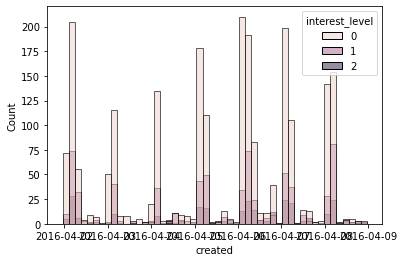

In [237]:
sns.histplot(new_created.loc["2016-04-01": "2016-04-08"],
             x="created",
             hue="interest_level",
             bins=50,
            )

**Проанализируем дни недели**

In [242]:
import datetime
counts = []
dates = []
daynumbers = []
for j in range(4, 7):
    for i in range(1, 30):
        dates.append(f"2016-{j}-{i}")
        daynumbers.append(datetime.datetime(2016, j, i).weekday())
        counts.append(len(new_created.loc[f"2016-{j}-{i}"]))

In [243]:
counts = pd.DataFrame({"date": dates, "count": counts, "daynumber": daynumbers})
counts

,date,count,daynumber
0,2016-4-1,2,4
1,2016-4-2,520,5
2,2016-4-3,254,6
3,2016-4-4,266,0
4,2016-4-5,462,1
...,...,...,...
82,2016-6-25,467,5
83,2016-6-26,216,6
84,2016-6-27,260,0
85,2016-6-28,495,1


**Получается, что по будням больше спрос, **

In [244]:
counts.groupby("daynumber").mean()

,count
daynumber,
0,264.333333
1,567.083333
2,582.153846
3,545.416667
4,468.846154
5,425.416667
6,277.692308


## Идеи для временных фичей
**Выходной?  (По выходным меньше заявок)**
**3 класса дня (0 - Понедельник, Вторник, Среда, 1 - Четверг, Пятница, 2 - Суббота воскрсенье) **
**Утро? 0 - 10**